<a href="https://colab.research.google.com/github/pranshumalik14/intuitive-arm-reach/blob/main/notebooks/planar_n_dof_training_datagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

import sys
sys.path.append('../scripts')
sys.path.append('../src')

# Purpose of notebook
- For a given robot and its respective training data, train an interpolator

# Sections of the notebook
1. Set up the robot object and respecify the task description
1. Load the csv data
1. Train the interpolator
1. Visualize the results

# 1. Set up Robot and task description
This includes number of basis functions (B), the time step (dt), the simulation time (T)

In [2]:
from robot_arm import RobotArm, RobotArm2D, RobotArm3D
from task_info import TaskInfo, numpy_linspace

robot_arm = RobotArm2D(
    n_dims      =   2,
    link_lengths=   np.array([0.6, 0.4])
)

lambda_init = 0.05  
lambda_min  = 0.05  
lambda_max  = 5     
dt          = 1e-2  
T           = 1     
h           = 10    
B           = 5
K           = 20    

N, _, _ = robot_arm.get_arm_params()


task_info = TaskInfo(
    robotarm    =   robot_arm,
    lambda_min  =   lambda_min,
    lambda_max  =   lambda_max,
    B           =   B,
    K           =   K,
    N           =   N,
    T           =   T,
    h           =   h,
    target_pos  =   None,
    dt          =   dt
)

In [ ]:
from training_data import gen_training_data
GEN_TRAIN_DATA = False
df = None

if GEN_TRAIN_DATA:
    
else:
    # load trained data
    # read data
    df = pd.read_csv('../training_data/sample_training_data_2D.csv')

## Data Descriptors
- Init joint angles: Joint configuration at time 0 of robot links
- x_target, y_target: desired target point on the plane for the end effector 
- Theta: output of the PIBB matrix (trained Theta)
- iter_count: (optional) number of iterations it took PIBB to reach to the final Theta
- Cost: (optional) cost function evaluated for this Theta 

Note: 
- this data is only for a specific 2D (planar) robot
- The last two params could be used for the interpolation algorithm (should prefer lower iter_count or cheaper cost)

# 2. Input Data Loading and Cleaning

In [4]:
from sys import platform

def str_to_floats(angle_str):
    angle_floats = angle_str[1:len(angle_str)-1].strip().split(" ")
    angle_floats = [angle for angle in angle_floats if angle != ""]
    angle_floats = [float(angle) for angle in angle_floats]
    return angle_floats

delimiter = "\r\n " if platform == "win32" else "\n "

# reshape x target
x_target = df['x_target']
x_target_np = x_target.to_numpy()
x_target = np.reshape(x_target_np, (x_target_np.shape[0], 1))

# rehsape y target
y_target = df['y_target']
y_target_np = y_target.to_numpy()
y_target = np.reshape(x_target_np, (y_target_np.shape[0], 1))

# reshape joint angles

joint_angles = df['init_joint_angles']
joint_angle_floats = []
for angles in joint_angles:
    joint_angle_floats.append(str_to_floats(angles))
joint_angle_np = np.array(joint_angle_floats)
joint_angles = joint_angle_np

# reshape theta

theta = df['Theta']
temp_theta = np.zeros(shape=(670, 5, 2)) #670 for each element, 2 for x & y, 5 for gaussian basis functions
for t in range(0, len(temp_theta)):
    if theta[t].startswith("[") and theta[t].endswith("]"):
        temp = theta[t][1:-1]
    else:
        print("Error")
    tp = temp.split(delimiter)
    for i in range(0, len(tp)):
        temp_array = str_to_floats(tp[i])
        temp_theta[t][i] = temp_array
   
theta = temp_theta

print("Input sizes are: \n", "joint angles: ", str(joint_angles.shape), "\nx_target: ",
 str(x_target.shape), "\ny_target: ", str(y_target.shape))
print("Output size is:\n theta: ", str(theta.shape))

Input sizes are: 
 joint angles:  (670, 2) 
x_target:  (670, 1) 
y_target:  (670, 1)
Output size is:
 theta:  (670, 5, 2)


In [5]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

concat_input = np.zeros(shape=(x_target.shape[0], 4)) # joint angles, x_target, y_target
normalize_joint_angles = NormalizeData(joint_angles)
normalize_x_target = NormalizeData(x_target)
normalize_y_target = NormalizeData(y_target)

for i in range(0, len(concat_input)):
    concat_input[i][0] = normalize_joint_angles[i][0]
    concat_input[i][1] = normalize_joint_angles[i][1]
    concat_input[i][2] = normalize_x_target[i]
    concat_input[i][3] = normalize_y_target[i]
concat_input = NormalizeData(concat_input)

print(theta.shape)
flatten_theta = np.zeros(shape=(theta.shape[0], theta.shape[1]*theta.shape[2]))
for i in range(0, len(flatten_theta)):
    flatten_theta[i] = theta[i].flatten()

(670, 5, 2)


# 3. Model Creation

In [6]:
from rbf_petra.rbflayer import RBFLayer
from rbf_petra.random_initializer import InitCentersRandom
from rbf_petra.kmeans_initializer import InitCentersKMeans

from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import mean_squared_error, cosine_similarity, mean_squared_logarithmic_error
import matplotlib.pyplot as plt 
import datetime

def tune_model_plot(input_data, output_data, num_layers=1, learning_rate=0.001, batch_size=10, initializer = "Random", 
    loss= "cosine_similarity", beta=2.0, validation_split=0.5, optimizer="Adam", epochs=300):
    
    model = Sequential()
    if initializer == "Random":
        tit_init= "rand"
        rbflayer = RBFLayer(10,
                            initializer=InitCentersRandom(concat_input),
                            betas=beta,
                            input_shape=(4,))
    elif initializer == "InitCentersKMeans":
        tit_init="kmeans"
        rbflayer = RBFLayer(batch_size,
                            initializer=InitCentersKMeans(concat_input),
                            betas=beta,
                            input_shape=(4,))
    else:
        print("Wrong initializer")
        return
    model.add(rbflayer)

    if num_layers == 1:
        tit_lay="1"
        pass
    elif num_layers == 2:
        tit_lay="2"
        model.add(Dense(50, activation='relu'))
    elif num_layers == 3:
        tit_lay="3"
        model.add(Dense(70, activation='relu'))
        model.add(Dense(40, activation='relu'))
    elif num_layers == 4:
        tit_lay="4"
        model.add(Dense(80, activation='relu'))
        model.add(Dense(60, activation='relu'))
        model.add(Dense(40, activation='relu'))
    else:
        print("Incorrect num_layers")
        return
    model.add(Dense(10))
    if optimizer == "Adam":
        tit_opt = "adam"
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "SGD":
        tit_opt = "sgd"
        tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False, name="SGD", **kwargs)
    elif optimizer == "RMSprop":
        tit_opt = "rmsprop"
        tf.keras.optimizers.RMSprop(
            learning_rate=learning_rate,
            rho=0.9,
            momentum=0.0,
            epsilon=1e-07,
            centered=False,
            name="RMSprop",
            **kwargs
        )
    else:
        print("Invalid optimizer")
        return
    if loss == "cosine_similarity":
        tit_loss = "cos_sim"
        model.compile(optimizer=opt, loss=cosine_similarity)
    elif loss == "MSE":
        tit_loss = "mse"
        model.compile(optimizer=opt, loss=mean_squared_error)
    elif loss == "MSElog":
        tit_loss = "mselog"
        model.compile(optimizer=opt, loss=mean_squared_logarithmic_error)
    else:
        print("Invalid loss")
        return
    history = model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=validation_split)

    w = 5
    h = 5
    d = 70
    fig = plt.figure(figsize=(w, h), dpi=d)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    txt = "num_layers=," + str(num_layers) + ", learning_rate=" + str(learning_rate) + ", batch_size=" + str(batch_size) + ", initializer=" + initializer + ",\nloss=" + loss + ", beta=" + str(beta) + ", validation_split=" + str(validation_split) + ", optimizer" + optimizer + ", epochs=" + str(epochs)

    fig_title = tit_init + "_" + str(epochs) + "_" + tit_lay + "_" + tit_loss + "_" + tit_opt
    plt.tight_layout()
    # text(0, 0, txt, ha='left', wrap=True)
    dt = datetime.datetime.today()
    title = str(dt.year) + "/" + str(dt.month) + "/" + str(dt.day) + " RBFPetra Implementation"
    # plt.title(title)
    plt.suptitle(title + "\n" + txt, fontsize=10, y=1.1)
    # plt.show()
    # TODO: savefig throws an error
    # fig.savefig('./parameter_tune_plots/' + fig_title + '.png', bbox_inches='tight')

    return model


2022-02-27 09:57:07.572501: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


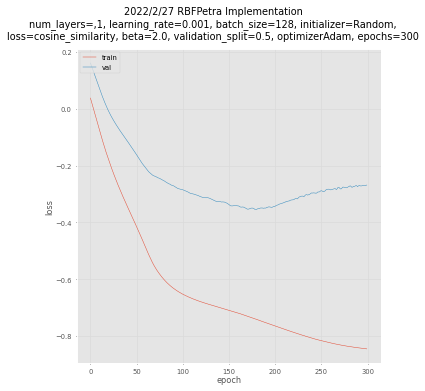

In [7]:
model = tune_model_plot(input_data=concat_input, output_data=flatten_theta, batch_size=128)

## Train Model

In [8]:
# import matplotlib.pyplot as plt 
# history = model.fit(concat_input, flatten_theta, batch_size=64, epochs=2000, verbose=0, validation_split=0.5)
# # list all data in history
# # # summarize history for accuracy
# # plt.plot(history.history['accuracy'])
# # plt.plot(history.history['val_accuracy'])
# # plt.title('model accuracy')
# # plt.ylabel('accuracy')
# # plt.xlabel('epoch')
# # plt.legend(['train', 'test'], loc='upper left')
# # plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# # print(history.history['loss'])
# plt.plot(history.history['val_loss'])
# # plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
# print(history.history['loss'][-1])


In [9]:
to_predict = np.array([0.53, -2.44, 0.6, 0.0])
to_predict.shape 
to_predict = np.reshape(to_predict, (1, 4))
to_predict.shape 


(1, 4)

In [10]:
model.save("model1")
# TODO: add code for loading a saved model
theta_predict = model.predict(to_predict)

2022-02-27 09:57:23.353061: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model1/assets


In [11]:
print(theta_predict.shape)

(1, 10)


In [12]:
theta_reshaped = np.reshape(theta_predict, (5,2))
print(theta_predict)
print(theta_reshaped)

[[-0.16221221 -0.2558739  -0.19223927  0.01075936 -0.14440268  0.03354013  0.03651492  0.01045243 -0.12360859 -0.06342027]]
[[-0.16221221 -0.2558739 ]
 [-0.19223927  0.01075936]
 [-0.14440268  0.03354013]
 [ 0.03651492  0.01045243]
 [-0.12360859 -0.06342027]]


# Visualization of theta

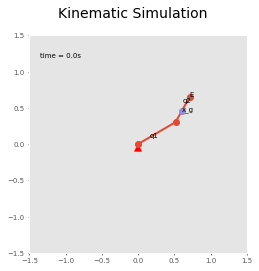

In [13]:
from PIBB_helper import qdotdot_gen
from pdff_kinematic_sim_funcs import get_traj_and_simulate2d, get_traj
import matplotlib.pyplot as plt

T = 1
dt = 1e-2
target_pt = [0.6, 0.0]
init_condit = [0.53, -2.44]

predicted_qdotdot = np.array(  
    [qdotdot_gen(task_info, theta_reshaped, t) for t in numpy_linspace(0, T, dt)]  
    )
    
# print(predicted_qdotdot.shape)
time_steps, q, qdot, gen_qdotdot, ani = get_traj_and_simulate2d(
    qdotdot     = predicted_qdotdot, 
    robot_arm   = robot_arm, 
    x_goal      = x_target, 
    init_condit = init_condit, 
    dt          = 1e-2
    )
plt.show()

## Model V2

In [14]:
import tensorflow as tf

In [15]:
# https://www.tensorflow.org/addons/tutorials/losses_triplet
